## Laboratorium 6


### Zbiór danych

Zbiór danych znajduje się w katalogu `dataset/*`. Jest to zmodyfikowany zbiór danych znajdujący się pod adresem: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE.NAZWISKO].zip
    +-- 📜 Lab[xx].ipynb
    +-- 📂 dataset
        +-- 📜 dataset.npz
        +-- 📜 ReadMe.pdf
```


### Zadanie 1

* Wybierz 10 pierwszych gatunków liści (będziesz je używać w kolejnych zadaniach), o identyfikatorach: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10.
* Znormalizuj dane w zakresie 0-1.
* Wybierz 2 najlepsze cechy.

### Zadanie 2

(kontynuacja zadania 1)

* Przeprowadź klasteryzację zbioru za pomocą metody [$k$-średnich](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
* Korzystając z metody łokcia (sprawdź liczbę klastrów od 1 do 50) wybierz liczbę klastrów ($c$).
* Podziel zbiór na $c$ klastrów.
* Wyświetl wyniki klasteryzacji dla $c$ klastrów w postaci wykresu (punktowego), na którym zaprezentowane są klastry oraz centroidy w różnych kolorach.

> Dla chętnych: zaimplementować samodzielnie metodę k-średnich i wyświetlić kolejne kroki klasteryzacji.




In [1]:
import numpy as np
import os
#Avoid warning in KMeans
os.environ["OMP_NUM_THREADS"] = "3"

with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

In [2]:
#Ladowanie danych
import numpy as np
with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']
    
#Create binary vector for given classes    
chosen_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
binary_vector_train = np.isin(train[:,0], chosen_id)
binary_vector_test = np.isin(test[:,0], chosen_id)

#Select only given classes
train_new = train[binary_vector_train]
test_new = test[binary_vector_test]

y_train = train_new[:,0].copy()
x_train = train_new[:,2:].copy()

y_test = test_new[:,0].copy()
x_test = test_new[:,2:].copy()

print("Dlugosc zbiory treningowego (labels):",len(y_train))
print("Dlugosc zbiory treningowego (data):",len(x_train))

print("Dlugosc zbiory testowego (labels):",len(y_test))
print("Dlugosc zbiory testowego (data):",len(x_test))

#Normalize data 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Fit on train data
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print("Wartosc min w zbiorze treningowym: ",np.min(x_train))
print("Wartosc max w zbiorze treningowym: ",np.max(x_train))

print("Wartosc min w zbiorze testowym: ",np.min(x_test))
print("Wartosc max w zbiorze testowym: ",np.max(x_test))

Dlugosc zbiory treningowego (labels): 671
Dlugosc zbiory treningowego (data): 671
Dlugosc zbiory testowego (labels): 517
Dlugosc zbiory testowego (data): 517
Wartosc min w zbiorze treningowym:  0.0
Wartosc max w zbiorze treningowym:  1.0000000000000002
Wartosc min w zbiorze testowym:  -0.15618629851288823
Wartosc max w zbiorze testowym:  1.087568483623526


In [3]:
import sklearn as skl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest

#Select f best features
selector = SelectKBest(k=2)
selector.fit(x_train,y_train)

#Take these features for training
x_train_f = selector.transform(x_train)
x_test_f = selector.transform(x_test)

#Check which features got selected
#Binary mask which features got selected
feature_binary = selector.get_support()
feature_indexes = np.where(feature_binary)[0]
feature_indexes = feature_indexes.astype(int).tolist()
print("Selected features: ", feature_indexes)

Selected features:  [1, 6]


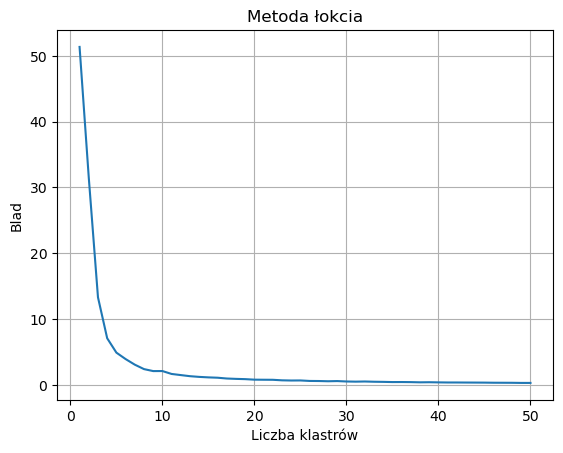

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
errors = []
for k in range(50):
    kmeans = KMeans(n_clusters=k+1)
    kmeans.fit(x_train_f)
    errors.append(kmeans.inertia_)

#Plot
k_range = np.arange(1,51,1)
plt.plot(k_range, errors)
plt.xlabel('Liczba klastrów')
plt.ylabel('Blad')
plt.title('Metoda łokcia')
plt.grid(True)
plt.show()

In [23]:
import numpy as np

def find_elbow_geom(errors):
    #Punkty
    k_vals = np.arange(1, len(errors) + 1)
    points = np.vstack((k_vals, errors)).T

    #Ab lines
    A = points[0]
    B = points[-1]
    AB = B - A
    AB_norm = AB / np.linalg.norm(AB)

    AP = points - A
    proj = np.dot(AP, AB_norm)[:, None] * AB_norm  # rzut AP na AB
    dist_vec = AP - proj
    distances = np.linalg.norm(dist_vec, axis=1)

    #Find elbow idx
    elbow_idx = np.argmax(distances)
    return k_vals[elbow_idx]

opt_k = find_elbow_geom(errors)
print("Optymalne k (geom.):", opt_k)

Optymalne k (geom.): 5


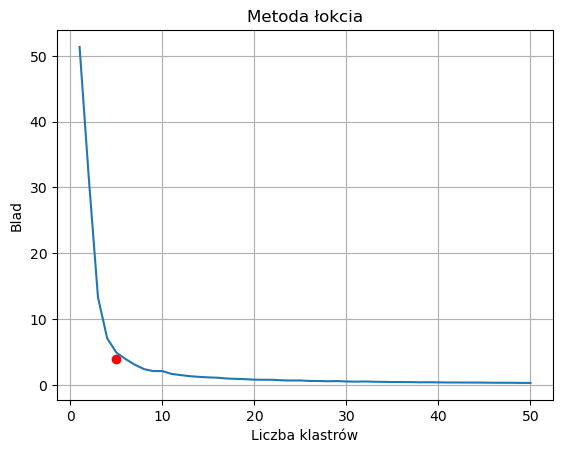

In [24]:
#Plot
plt.scatter(opt_k, errors[opt_k], c = "r")
plt.plot(k_range, errors)
plt.xlabel('Liczba klastrów')
plt.ylabel('Blad')
plt.title('Metoda łokcia')
plt.grid(True)
plt.show()

In [25]:
#Klusteryzacja
kmeans = KMeans(n_clusters=5)
kmeans.fit(x_train_f)

y_pred = kmeans.predict(x_test_f)

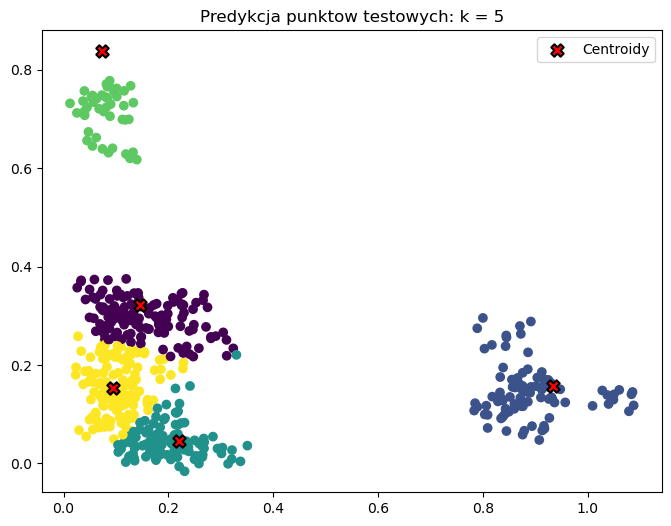

In [31]:

plt.figure(figsize=(8, 6))
plt.title("Predykcja punktow testowych: k = 5")
plt.scatter(x_test_f[:, 0], x_test_f[:, 1], c=y_pred, marker='o')

#Centroidy
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X',s=80, edgecolor='k',c = "r", linewidth=1.5, label='Centroidy')
plt.legend()